<a href="https://colab.research.google.com/github/Cami9000/Assignment/blob/main/Assignment_DL_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path = '/content/drive/My Drive/Assignment DL/train.csv'


In [3]:
import pandas as pd
train_df = pd.read_csv('/content/drive/My Drive/Assignment DL/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/Assignment DL/test.csv')
sample_df = pd.read_csv('/content/drive/My Drive/Assignment DL/sample_submission.csv')

# **STEP 1**

Is it unsupervised or supervised ML?

- It is a supervised learning problem because we want to figure out if a costumer is willing to buy another insurance which needs to be predicted based on the other features in the dataset.

# **STEP 2**

Is it a classification or regression problem?

- t is classification, because the target is binary: either the costumer buys another insurance, or they don't.  So in this situation, we have a "buying" or "not buying"

If we on the other hand should analyse how many insurance the costumer would buy, it would have been a regression problem.

# **STEP 3**

Do we need traditional ML or Deep Learning?

We have to use DL, because we have a big dataset (11 million rows) and we have a lot of features, which make the dataset more complex.


# **STEP 4**

Train DL

# **1. Feature Selection**

**Identify the most relevant features (columns) for predicting your target variable.**

In [4]:
# Getting an overview of the dataset
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [5]:
# To check which features would be best to analyse with, we make a correlation matrix to see which features have a correlation to eachother
# Only want the numeric data
numeric_df = train_df.select_dtypes(include=['number'])

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Sort features with highest correlation to Response, that this is our target variable.
corr_target = corr_matrix["Response"].abs().sort_values(ascending=False)
print(corr_target)


Response                1.000000
Previously_Insured      0.345930
Policy_Sales_Channel    0.152733
Age                     0.122134
Annual_Premium          0.032261
Vintage                 0.015177
Region_Code             0.012816
Driving_License         0.009197
id                      0.000018
Name: Response, dtype: float64


**Provide a rationale for why these features are important or hypothesized to be predictive.**


I have selected features with a correlation above 0.10, as they have a moderate to strong relationship with Response and are expected to be predictive of house prices.

- Previously_Insured - if a customer already has insurance, it likely influences their decision to buy more
- Policy_Sales_Channel - The sales channel can have a moderate effect on whether the customer buys.
- Age - Age may play a role – perhaps older people are more likely to buy.

# **2. Feature Engineering**

**Create or transform features that might enhance predictive power.**

(Encode categorical features (e.g., one-hot encoding).)


In [6]:
train_df["Vehicle_Damage"].unique()

array(['Yes', 'No'], dtype=object)

In [7]:
train_df["Vehicle_Age"].unique()

array(['1-2 Year', '> 2 Years', '< 1 Year'], dtype=object)

In [8]:
# ML only understands numeric data and not text data
# Features like "Vehicle_Age" and "Vehicle_Damage" are categorical and need to be converted to numbers (0 = No, 1 = Yes)

train_df["Vehicle_Age"] = train_df["Vehicle_Age"].replace({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}).astype(int)
train_df["Vehicle_Damage"] = train_df["Vehicle_Damage"].replace({"No": 0, "Yes": 1}).astype(int)

test_df["Vehicle_Age"] = test_df["Vehicle_Age"].replace({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}).astype(int)
test_df["Vehicle_Damage"] = test_df["Vehicle_Damage"].replace({"No": 0, "Yes": 1}).astype(int)


<ipython-input-8-b0e51a0f934c>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df["Vehicle_Age"] = train_df["Vehicle_Age"].replace({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}).astype(int)
<ipython-input-8-b0e51a0f934c>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df["Vehicle_Damage"] = train_df["Vehicle_Damage"].replace({"No": 0, "Yes": 1}).astype(int)
<ipython-input-8-b0e51a0f934c>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behav

In [9]:
# Checking that the feature Vehicle_Age is converted correctly
train_df["Vehicle_Age"].unique()

array([1, 2, 0])

In [10]:
# If a customer has previously had insurance ("Previously Insured" = 1), but their vehicle has had damage
# ("Vehicle_Damage" = 1), they may be more likely to purchase new insurance.
train_df["Insurance_Gap"] = train_df["Vehicle_Damage"] - train_df["Previously_Insured"]
test_df["Insurance_Gap"] = test_df["Vehicle_Damage"] - test_df["Previously_Insured"]

# Value = 1 - Customer has had a claim but no previous insurance = High chance of buying insurance
# Value = 0 - Customer has either had previous insurance or no claim
# Value = -1 - Customer had insurance and no claim

In [11]:
# A customer with an old vehicle ("Vehicle Age") + previous damage ("Vehicle Damage") + high annual premium
#("Annual_Premium") may be at higher risk.

train_df["Risk_Score"] = train_df["Vehicle_Age"] + train_df["Vehicle_Damage"] + (train_df["Annual_Premium"] / train_df["Annual_Premium"].max())
test_df["Risk_Score"] = test_df["Vehicle_Age"] + test_df["Vehicle_Damage"] + (test_df["Annual_Premium"] / test_df["Annual_Premium"].max())

# Higher value = higher risk


In [12]:
# Age can have a non-linear effect on the purchase decision.
# We can group it into categories
train_df["Age_Group"] = pd.cut(train_df["Age"], bins=[18, 25, 35, 50, 100], labels=[0, 1, 2, 3])
test_df["Age_Group"] = pd.cut(test_df["Age"], bins=[18, 25, 35, 50, 100], labels=[0, 1, 2, 3])

# 0 = Young customers (18-25)
# 1 = Adults (26-35)
# 2 = Middle-aged (36-50)
# 3 = Older (50+)


# Prevents outliers in age from creating noise
# Gives the model a better understanding of the importance of age

# **Data Preprocessing**

**Handle missing values (e.g., imputation, removal).**


In [13]:
# Check missing values
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Only show columns with missing values
print(missing_values)

# Our output shows not how many missing values is in the columns


Series([], dtype: int64)


**Normalize/standardize numerical features (e.g., Min-Max or StandardScaler).**

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Chosing the features that has to be scaled
num_features = ["Age", "Annual_Premium", "Vintage", "Risk_Score"]

scaler = MinMaxScaler()

# Fit-transform on train data
train_df[num_features] = scaler.fit_transform(train_df[num_features])

# Transform test data
test_df[num_features] = scaler.transform(test_df[num_features])

# Checking the scaled value is between 0 og 1
print(train_df[num_features].describe())

                Age  Annual_Premium       Vintage    Risk_Score
count  1.150480e+07    1.150480e+07  1.150480e+07  1.150480e+07
mean   2.828241e-01    5.177592e-02  5.325181e-01  2.896803e-01
std    2.306686e-01    3.061149e-02  2.767458e-01  2.249747e-01
min    0.000000e+00    0.000000e+00  0.000000e+00  0.000000e+00
25%    6.153846e-02    4.213121e-02  3.079585e-01  1.664481e-02
50%    2.461538e-01    5.431088e-02  5.397924e-01  2.648976e-01
75%    4.461538e-01    6.849973e-02  7.681661e-01  5.132107e-01
max    1.000000e+00    1.000000e+00  1.000000e+00  1.000000e+00


In [30]:
from sklearn.model_selection import train_test_split

# Sampling
sample_size = 500000  # Taking 500k rows from 11.5M

df_sample, _ = train_test_split(train_df, train_size=sample_size, stratify=train_df["Response"], random_state=42)

print(f"Sampled Dataset Shape: {df_sample.shape}")


Sampled Dataset Shape: (500000, 15)


# **Train-Test (or Train-Validation-Test) Split**

Split your data into appropriate sets.
Consider using a validation set or cross-validation to fine-tune hyperparameters.

In [31]:
from sklearn.model_selection import train_test_split

# Dine udvalgte features
selected_features = [
    "Previously_Insured", "Policy_Sales_Channel", "Age",
    "Vehicle_Age", "Vehicle_Damage", "Insurance_Gap",
    "Risk_Score", "Age_Group", "Annual_Premium", "Vintage"
]

# Definér X (features) og y (target)
X = df_sample[selected_features]  # Features
y = df_sample["Response"]  # Target (det vi vil forudsige)

# Først laver vi en 85% træning + 15% test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Dernæst splitter vi træningsdata i 70% træning + 15% validering
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42, stratify=y_train)

# Tjek størrelsen af de tre sæt
print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Train set: (349987, 10), Validation set: (75013, 10), Test set: (75000, 10)


# **Define Your Neural Network Architecture in PyTorch**

**MLP (if your data is purely cross-sectional):**

At least 2 hidden layers.
Common activation functions (e.g., ReLU, Sigmoid, Tanh).
Consider using dropout or batch normalization if helpful.

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import EditedNearestNeighbours

In [33]:
# Step 1: Load and Preprocess Data
def load_and_preprocess_data(X_train, y_train, X_val, y_val, X_test, y_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, val_loader, test_loader

In [34]:
# Step 2: Feature Engineering (already done in preprocessing)

In [52]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# **Training Loop**

Implement a standard PyTorch training loop.
Specify an appropriate loss function (e.g., MSE for regression, CrossEntropy for classification).
Choose an optimizer (e.g., Adam, SGD).
Track metrics (training/validation loss, accuracy, or other relevant metrics).

In [53]:
# Step 4: Training Loop
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation step
        model.eval()
        val_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()
                predicted = (y_pred > 0.5).float()
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)

        val_acc = correct / total
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    return train_losses, val_losses

# **Hyperparameter Experiments**

Test different hyperparameters (e.g., hidden layers, learning rate, batch size) to observe changes in performance.
Record and discuss these experiments.

In [54]:
# Step 5: Hyperparameter Experiments
def hyperparameter_experiment(X_train, y_train, X_val, y_val, X_test, y_test):
    train_loader, val_loader, test_loader = load_and_preprocess_data(X_train, y_train, X_val, y_val, X_test, y_test)
    input_dim = X_train.shape[1]

    best_lr = None
    best_acc = 0

    for lr in [0.01, 0.001, 0.0001]:
        print(f"Testing learning rate: {lr}")
        model = MLP(input_dim)
        train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=10, lr=lr)

        # Evaluate on validation set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                predicted = (y_pred > 0.5).float()
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        val_acc = correct / total

        if val_acc > best_acc:
            best_acc = val_acc
            best_lr = lr

    print(f"Best Learning Rate: {best_lr} with Validation Accuracy: {best_acc:.4f}")

# **Model Evaluation**

Evaluate your final model(s) on the test set.
Use appropriate metrics (e.g., RMSE, MAE, R² for regression tasks; accuracy, F1-score, etc. for classification tasks).
Provide plots of the training process (loss curves, etc.) and any model diagnostics.

In [55]:
# Step 6: Model Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            predicted = (y_pred > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")
    return test_acc


Epoch 1/10 | Train Loss: 0.2715 | Val Loss: 0.2682 | Val Acc: 0.8770
Epoch 2/10 | Train Loss: 0.2688 | Val Loss: 0.2668 | Val Acc: 0.8770
Epoch 3/10 | Train Loss: 0.2681 | Val Loss: 0.2667 | Val Acc: 0.8770
Epoch 4/10 | Train Loss: 0.2677 | Val Loss: 0.2672 | Val Acc: 0.8770
Epoch 5/10 | Train Loss: 0.2674 | Val Loss: 0.2664 | Val Acc: 0.8770
Epoch 6/10 | Train Loss: 0.2672 | Val Loss: 0.2682 | Val Acc: 0.8770
Epoch 7/10 | Train Loss: 0.2670 | Val Loss: 0.2658 | Val Acc: 0.8770
Epoch 8/10 | Train Loss: 0.2670 | Val Loss: 0.2662 | Val Acc: 0.8770
Epoch 9/10 | Train Loss: 0.2669 | Val Loss: 0.2658 | Val Acc: 0.8770
Epoch 10/10 | Train Loss: 0.2667 | Val Loss: 0.2654 | Val Acc: 0.8770


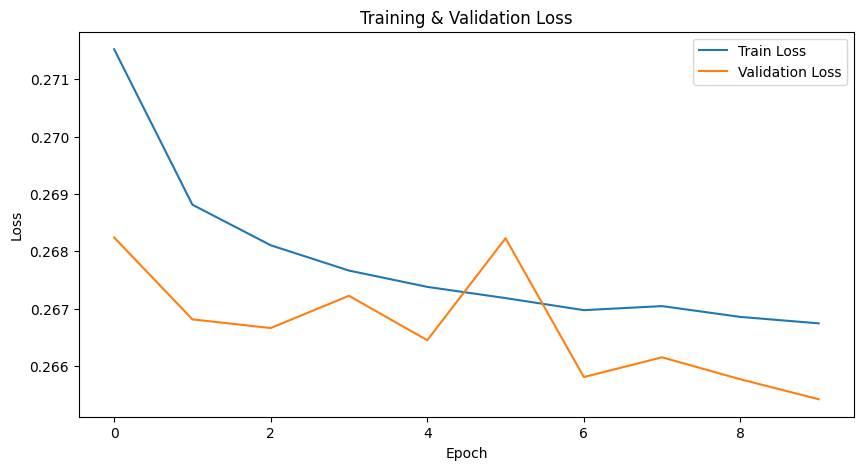

In [56]:
# Step 7: Training Visualization
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')
    plt.show()

# Load data
train_loader, val_loader, test_loader = load_and_preprocess_data(X_train, y_train, X_val, y_val, X_test, y_test)

# Initialize model
input_dim = X_train.shape[1]
model = MLP(input_dim)

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=10, lr=0.0005)

# Plot the training loss curves
plot_losses(train_losses, val_losses)
